In [1]:
import pandas as pd

In [2]:
#events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression='zip')
#submission_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression='zip')
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression='zip')
submission_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression='zip')
#bad data
#events_data = pd.read_csv('C:\Users\taerd\ML-python\second module\events_data_train.csv')
#submission_data = pd.read_csv('C:\Users\taerd\ML-python\second module\submission_data_train.csv')

In [3]:
submission_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [4]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
# перевод timestamp to datetime
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date

submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit = 's')
submission_data['day'] = submission_data.date.dt.date

In [6]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [7]:
days=events_data.groupby('user_id').day.nunique()

In [8]:
days.nunique()

121

In [9]:
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [10]:
# последний заход в онлайн пользователя
users_data = events_data.groupby('user_id', as_index = False)\
                    .agg({'timestamp' : 'max'})\
                    .rename({'timestamp' : 'last_timestamp'},axis =1)

In [11]:
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [12]:
now=users_data.last_timestamp.max()

In [13]:
# уникальный timestampy для пользователей 
users_timestamps = events_data[['user_id','day','timestamp']].drop_duplicates(subset = ['user_id','day']).groupby('user_id')['timestamp'].apply(list)

In [14]:
import numpy as np
gap_data = users_timestamps.apply(np.diff).values
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int32)], dtype=object)

In [15]:
# перевод array arrayev в один array
gap_data=pd.Series(np.concatenate(gap_data,axis=0))
#делим разницу между заходами в timestamp на дни
gap_data=gap_data/(24*60*60)

In [16]:
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

In [17]:
gap_data.quantile(0.9)

18.325995370370403

In [18]:
gap_data.quantile(0.95)

59.760440972222156

<AxesSubplot:>

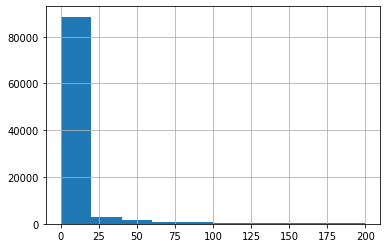

In [19]:
gap_data[gap_data<200].hist()

In [20]:
# месячный переод для дропаут с курса
drop_out_threasold = 60*60*24*30

In [21]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threasold

In [22]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [23]:
# таблица из количества верных\неверных ответов
users_scores = submission_data.pivot_table(index = 'user_id', \
                                          columns = 'submission_status', \
                                          values = 'step_id', \
                                           aggfunc = 'count',\
                                          fill_value = 0)\
                                          .reset_index()

In [24]:
users_scores.head(10)

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
5,16,77,106
6,17,0,2
7,22,76,47
8,25,1,4
9,26,7,16


In [25]:
# объединение таблиц без потери (пустые результаты заполняются NaN)
users_data = users_data.merge(users_scores , on = 'user_id', how = 'outer')

In [26]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [27]:
users_data = users_data.fillna(0)

In [28]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [29]:
# узнаем сколько попыток было на каждый action
users_invent_data = events_data.pivot_table(index='user_id',\
                                           columns = 'action', \
                                           values = 'step_id',\
                                           aggfunc = 'count',\
                                           fill_value = 0).reset_index()

In [30]:
users_invent_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [31]:
users_data = users_data.merge(users_invent_data, on = 'user_id' , how = 'outer')

In [32]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [33]:
# количетсво уникальных дней пользователя
users_days = events_data.groupby('user_id').day.nunique()

In [34]:
users_days.head()

user_id
1    1
2    2
3    7
5    2
7    1
Name: day, dtype: int64

In [35]:
users_days.to_frame().reset_index()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [36]:
users_days.nunique()

121

In [37]:
users_data = users_data.merge(users_days, on = 'user_id', how = 'outer')

In [38]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


<AxesSubplot:>

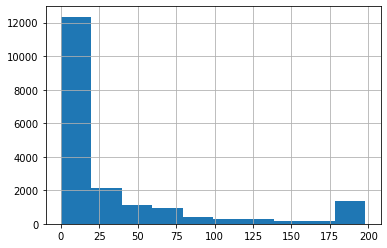

In [39]:
users_data.passed.hist()

In [40]:
users_data.passed.quantile(0.9)

122.0

In [41]:
# добавление колонки пройденного курса (больше 170 степов passed)
users_data['passed_course'] = users_data.passed > 170

In [42]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


20.0

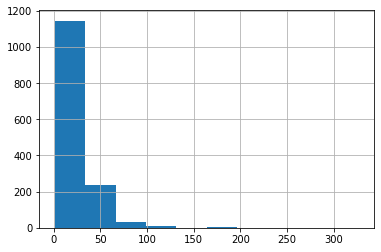

In [43]:
# распределение дней у пользователей прошедших курс
users_data[users_data.passed_course].day.hist();
# среднее значение прошедших курс в днях
users_data[users_data.passed_course].day.median()

In [44]:
#  первый заход пользователя на курс
user_min_time =events_data.groupby('user_id', as_index = False) \
                            .agg({'timestamp' : 'min'})\
                            .rename({'timestamp' : 'min_timestamp'},axis =1)

In [45]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [46]:
users_data = users_data.merge(user_min_time,on = 'user_id', how = 'outer')

In [47]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [48]:
users_data.shape

(19234, 12)

In [49]:
# предсказания дропнется user или нет в течении 3дней с момента первого захода

In [50]:
learning_time_threshold = 5 *24 *60*60

In [51]:
users_data['min+3days']= users_data.min_timestamp+learning_time_threshold

In [52]:
users_data3 = users_data[['user_id','min+3days']]

In [53]:
users_data3.head()

,user_id,min+3days
0,1,1473259464
1,2,1514815364
2,3,1434790476
3,5,1466588809
4,7,1522066660


In [54]:
events_data_3 = events_data.merge(users_data3 , on ='user_id',how ='outer')

In [55]:
events_data_3.head()

,step_id,timestamp,action,user_id,date,day,min+3days
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434772848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434772848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434772848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434772848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434772848


In [56]:
events_data_3.shape

(3480703, 7)

In [57]:
# отбор событий пользователя за 3 дня с момента первого входа
events_data_3days = events_data_3[events_data_3['timestamp']<= events_data_3['min+3days']]

In [58]:
events_data_3days.shape

(1193207, 7)

In [59]:
events_data_3days.head()

,step_id,timestamp,action,user_id,date,day,min+3days
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434772848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434772848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434772848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434772848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434772848


In [60]:
#  Нахождение сложного степа, на котором больше всего ошибочных результатов
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [61]:
steps_data = submission_data.pivot_table(index = 'step_id', \
                                          columns = 'submission_status', \
                                          values = 'user_id', \
                                           aggfunc = 'count',\
                                          fill_value = 0)\
                                          .reset_index()\
                                           

In [62]:
steps_data.head()

submission_status,step_id,correct,wrong
0,31971,6257,6893
1,31972,6434,8960
2,31976,6580,5937
3,31977,6800,6457
4,31978,6094,16084


In [63]:
steps_data[steps_data['wrong'] == steps_data['wrong'].max()]

submission_status,step_id,correct,wrong
4,31978,6094,16084


In [64]:
# Проверка на количество уникальных дней с момента первого входа на курс и до первого входа+3дня.больше 4 дней получить нельзя
events_data_3days.groupby('user_id').day.nunique().max()

6

In [65]:
# отбираем submissions data для пользователей в течении 3 дней после 1 входа на курс (уже сделали для events_data)

In [66]:
submission_data_3 = submission_data.merge(users_data3,on = 'user_id',how = 'outer')

In [67]:
submission_data_3.head()

,step_id,timestamp,submission_status,user_id,date,day,min+3days
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434777977
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434777977
2,31972.0,1.478852e+09,wrong,15853,2016-11-11 08:15:49,2016-11-11,1434777977
3,31972.0,1.478852e+09,correct,15853,2016-11-11 08:16:04,2016-11-11,1434777977
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434777977


In [68]:
submission_data_3days = submission_data_3[submission_data_3.timestamp <= submission_data_3['min+3days']]

In [69]:
submission_data_3days.head()

,step_id,timestamp,submission_status,user_id,date,day,min+3days
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434777977
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434777977
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434777977
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434777977
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434777977


In [70]:
# Проверка на количество уникальных дней с момента первого входа на курс и до первого входа+3дня.больше 4 дней получить нельзя
submission_data_3days.groupby('user_id').day.nunique().max()

6

In [71]:
# Прогнозирование дропаута пользователя
# 'Правильные' ответы на users_data.is_gone_user

In [72]:
# уникальное количество дней проведенных в промежутке от первого входа до первого входа+3дня для каждого пользователя
X = submission_data_3days.groupby('user_id').day.nunique().to_frame().reset_index()\
.rename(columns = {'day' : 'days'})

In [73]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,4


In [74]:
# количество степов просмотреных пользователем
steps_tried = submission_data_3days.groupby('user_id').step_id.nunique().to_frame().reset_index() \
.rename(columns={'step_id' : 'steps_tried'})

In [75]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,24


In [76]:
X = X.merge(steps_tried, on = 'user_id', how = 'outer')

In [77]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,4,24


In [78]:
# добавление результатов о решенных степах
X = X.merge(submission_data_3days.pivot_table(index = 'user_id',
                                 columns = 'submission_status',
                                 values = 'step_id',
                                 aggfunc = 'count',
                                 fill_value = 0).reset_index(),
            on = 'user_id',how = 'outer')

In [79]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,4,24,23,28


In [80]:
X['correct_ratio'] = X.correct/(X.correct+X.wrong)

In [81]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00000
1,3,1,4,4,4,0.50000
2,8,1,11,9,21,0.30000
3,14,1,1,0,1,0.00000
4,16,4,24,23,28,0.45098


In [82]:
# также добавим сколько за 3 дня пользователь просмотрел степов
X = X.merge(events_data_3days.pivot_table(index = 'user_id',
                                         columns = 'action',
                                         values = 'step_id',
                                         aggfunc = 'count',
                                         fill_value=0).reset_index()[['user_id','viewed']],
           on = 'user_id',how = 'outer')

In [83]:
X = X.fillna(0)

In [84]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00000,9
1,3,1.0,4.0,4.0,4.0,0.50000,20
2,8,1.0,11.0,9.0,21.0,0.30000,154
3,14,1.0,1.0,0.0,1.0,0.00000,9
4,16,4.0,24.0,23.0,28.0,0.45098,140


In [85]:
# размечаем выборку, для этого добавляем промежуточные значения 
X = X.merge(users_data[['user_id','passed_course', 'is_gone_user']],on ='user_id',how='outer')

In [86]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00000,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50000,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30000,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00000,9,False,True
4,16,4.0,24.0,23.0,28.0,0.45098,140,True,True


In [87]:
# количество совпало с колиством всех пользователей(так проверка)
X.shape

(19234, 9)

In [88]:
# человек  (прошел курс и (бросил или не бросил)) либо (бросил) . т е убираем тех, кто ушел и не прошел курс
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [89]:
X.shape

(17985, 9)

In [90]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00000,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50000,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30000,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00000,9,False,True
4,16,4.0,24.0,23.0,28.0,0.45098,140,True,True


In [91]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [92]:
# целевой переменной будет passed_course тк у нас все не прошедшие помечены как дропнутые
y = X.passed_course.map(int)

In [93]:
# убираем ненужную для обучения информацию
X = X.drop(['passed_course','is_gone_user'],axis = 1)

In [94]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00000,9
1,3,1.0,4.0,4.0,4.0,0.50000,20
2,8,1.0,11.0,9.0,21.0,0.30000,154
3,14,1.0,1.0,0.0,1.0,0.00000,9
4,16,4.0,24.0,23.0,28.0,0.45098,140


In [95]:
# не удаляем user_id,  для обучения он нам не пригодится, но может пригодится для плюшек если ушел(чтобы кому отправлять)
X = X.set_index(X.user_id)
X =X.drop('user_id',axis=1)

In [96]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00000,9
3,1.0,4.0,4.0,4.0,0.50000,20
8,1.0,11.0,9.0,21.0,0.30000,154
14,1.0,1.0,0.0,1.0,0.00000,9
16,4.0,24.0,23.0,28.0,0.45098,140


In [97]:
y.head

<bound method NDFrame.head of 0        0
1        0
2        0
3        0
4        1
        ..
19229    0
19230    1
19231    0
19232    0
19233    0
Name: passed_course, Length: 17985, dtype: int64>

In [98]:
# обучение на данных
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [100]:
X_train.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
16181,0.0,0.0,0.0,0.0,0.0,1
26601,1.0,2.0,2.0,0.0,1.0,20
529,0.0,0.0,0.0,0.0,0.0,1
59,0.0,0.0,0.0,0.0,0.0,1
7574,0.0,0.0,0.0,0.0,0.0,1


In [101]:
y_train.head()

15201    0
8974     0
9246     0
9065     0
11905    0
Name: passed_course, dtype: int64

In [102]:
dt = tree.DecisionTreeClassifier()

In [103]:
parameters = {'criterion' : ['gini','entropy'],      
              'max_depth': range(1,6),
              'min_samples_leaf': range(2,5),
              'min_samples_split':range(2,5),
              'max_leaf_nodes':range(6,15)}

In [104]:
grid_search_cv_clf = GridSearchCV(dt,parameters,cv=5,scoring = 'f1')

In [105]:
grid_search_cv_clf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 6),
                         'max_leaf_nodes': range(6, 15),
                         'min_samples_leaf': range(2, 5),
                         'min_samples_split': range(2, 5)},
             scoring='f1')

In [106]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_leaf_nodes': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [107]:
best_dt = grid_search_cv_clf.best_estimator_

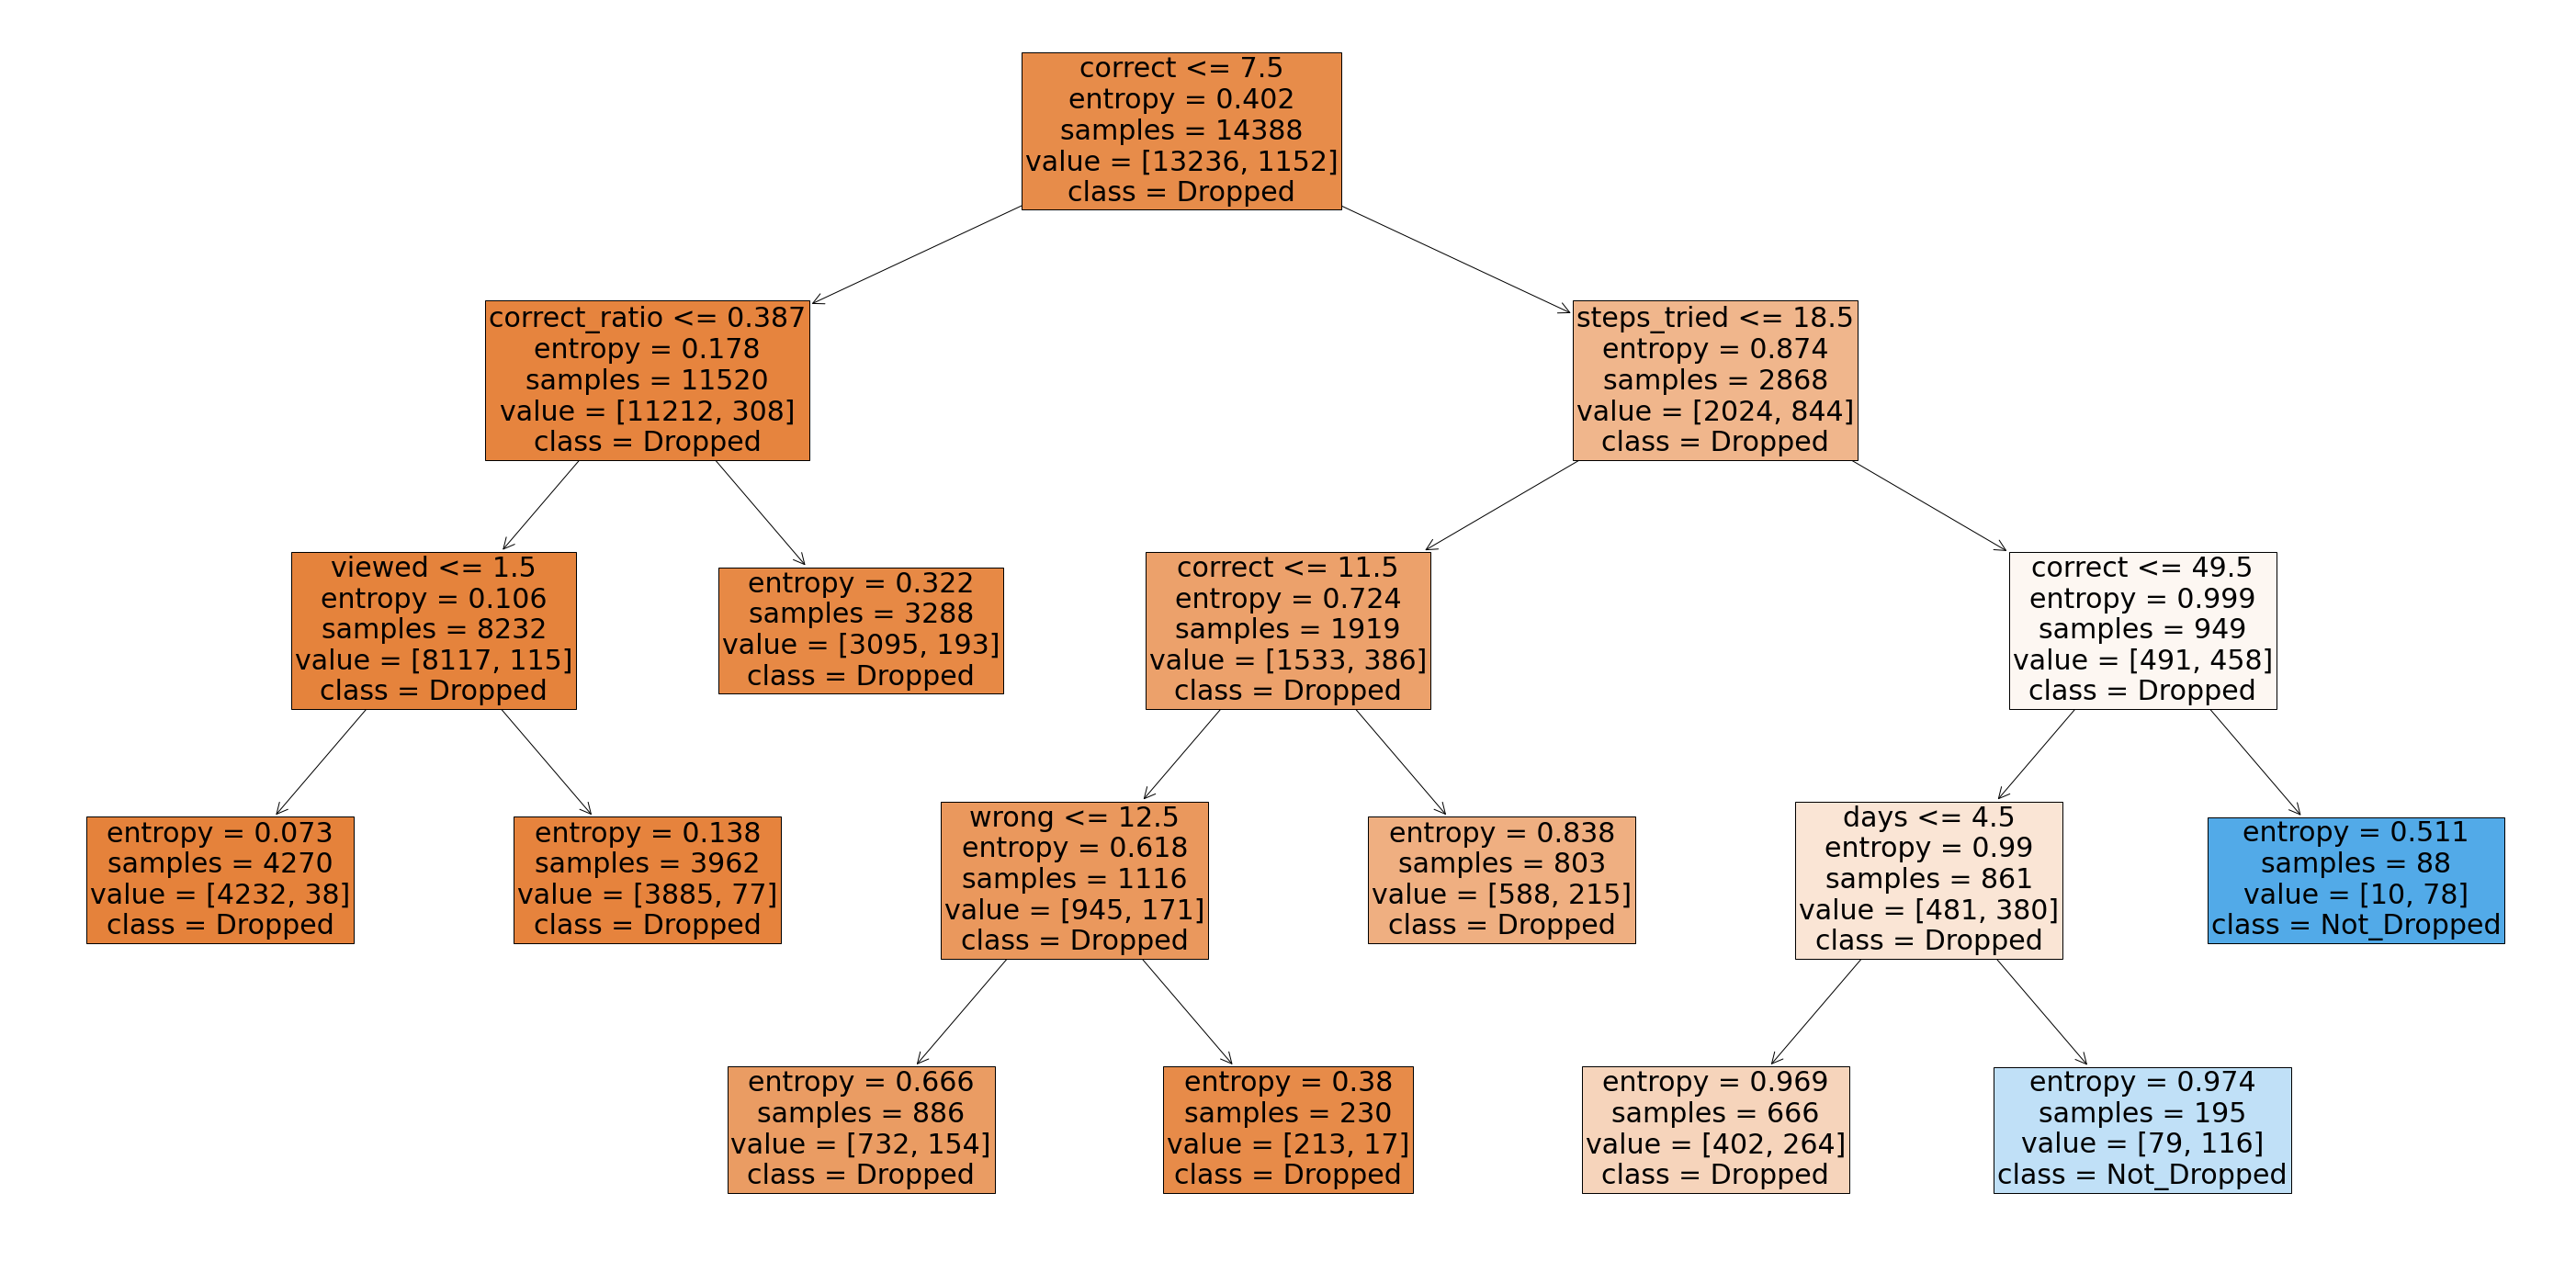

In [108]:
plt.figure(figsize=(50,25))
tree.plot_tree(best_dt,
               feature_names=list(X_train),
               class_names=['Dropped','Not_Dropped'],
               filled=True,
               fontsize = 30);
plt.show()

In [109]:
# однако есть дисбаланс классов
best_dt.score(X_test,y_test)

0.9299416180150125

In [110]:
# подсчет метрик
from sklearn.metrics import precision_score , recall_score

In [111]:
predictions = best_dt.predict(X_test)

In [112]:
pr_score = precision_score(y_test,predictions)

In [113]:
rec_score = recall_score(y_test, predictions)

In [114]:
pr_score

0.6329113924050633

In [115]:
rec_score

0.18315018315018314

In [116]:
F = pr_score*rec_score/(pr_score+rec_score)

In [117]:
F

0.14204545454545453

In [118]:
# узнаем вероятности соотнесения к некоторым классам
y_predicted_prob = best_dt.predict_proba(X_test)

In [119]:
y_predicted_prob

array([[0.9413017 , 0.0586983 ],
       [0.98056537, 0.01943463],
       [0.6036036 , 0.3963964 ],
       ...,
       [0.9413017 , 0.0586983 ],
       [0.9911007 , 0.0088993 ],
       [0.9413017 , 0.0586983 ]])

<AxesSubplot:>

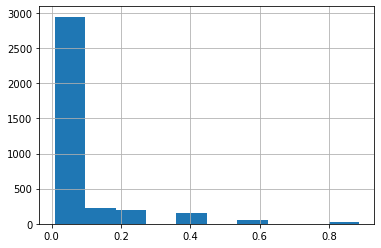

In [120]:
pd.Series(y_predicted_prob[:,1]).hist()

In [121]:
# максимизация recall ( в класс дропнувшихся отправлять тех, у кого вероятность >0.2)
import numpy as np

In [122]:
pd.Series(y_predicted_prob[:,1]).unique()

array([0.0586983 , 0.01943463, 0.3963964 , 0.07391304, 0.0088993 ,
       0.1738149 , 0.26774595, 0.59487179, 0.88636364])

In [123]:
y_pred = np.where(y_predicted_prob[:,1] > 0.25 , 1 ,0)

In [124]:
pr_score = precision_score(y_test,y_pred)
pr_score

0.3819444444444444

In [125]:
rec_score = recall_score(y_test,y_pred)
rec_score

0.6043956043956044

In [126]:
F = (pr_score*rec_score)/(pr_score+rec_score)
F

0.23404255319148934

In [127]:
# нахождение баланса между precision и recall

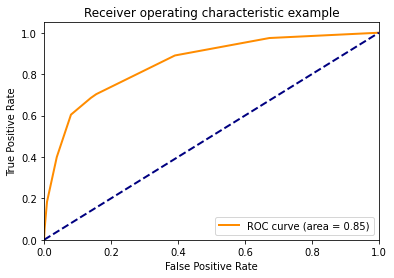

In [128]:
# true positive rate(recall) - какой процент пользователей которые дропнулись 
# мы действительно классифицировали как дропнулся
#
# false positive rate - 
# для какого процента людей не дропнувшихся мы ошиблись
# ( т. е не дропнулся на самом деле)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [129]:
# linearRegression
from sklearn.linear_model import LogisticRegressionCV

In [130]:
clf = LogisticRegressionCV(cv=5, random_state = 10).fit(X_train,y_train)

In [131]:
# дисбаланс классов
clf.score(X_test,y_test)

0.9299416180150125

In [132]:
y_pred = clf.predict(X_test)

In [133]:
pr_score = precision_score(y_test,y_pred)
pr_score

0.6

In [134]:
rec_score = recall_score(y_test,y_pred)
rec_score

0.23076923076923078

In [135]:
F = (pr_score*rec_score) / (rec_score+pr_score)
F

0.16666666666666669